#### **PNGolin Test Notebook**

Demonstrates how to use PNGolin to compute the power spectrum, bispectrum, and trispectrum from a field. To test the estimators, we create Gaussian random fields using the Pylians package.

##### **Initialize Notebook**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pngolin

import density_field_library as DFL
import os


from scipy.interpolate import interp1d
from tqdm import tqdm

%config InlineBackend.figure_format='retina'

# Latex settings
os.environ["PATH"] += os.pathsep + '/work2/09407/samgolds/stampede3/lib/texlive/install-tl-20240416/bin/x86_64-linux'
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['text.usetex'] = True  

# Settings for simulations
Ngrid    = 128
BoxSize  = 1000 # Mpc/h
kF       = 2*np.pi/BoxSize
kNyq     = Ngrid//2*kF
nthreads = 8

##### **Test on Gaussian Random Fields**

Set fiducial power spectrum and construct a single Gaussian random fields, $\Phi_G(\bf{x})$. 

In [2]:
# Use small scale-invariant P(k) for fiducial cosmo.
k_thr  = np.logspace(-4, 1, 10000)
Pk_thr = (1e-9*k_thr**-3)

# Pad interpolator
k_thr = np.append([0.0], k_thr).astype(np.float32)
Pk_thr = np.append([0.0], Pk_thr).astype(np.float32)
Pk_interp = interp1d(k_thr, Pk_thr)

# Generate a single realization of the field
seed = np.random.randint(1e8)      #value of the initial random seed
delta_x = DFL.gaussian_field_3D(Ngrid, k_thr, Pk_thr, Rayleigh_sampling=0, seed=seed,
                                BoxSize=BoxSize, threads=nthreads, verbose=True)
delta_k = pngolin.initialize_delta(delta_x, MAS='CIC', nthreads=nthreads)

delta(k) field generated
time taken = 0.16524 seconds



##### **Power spectrum**

To compute the power spectrum, we specify $k_{\rm min}$, $k_{\rm max}$, and $dk$. All of these are integers and in units of the fundamental frequency, $k_F$. 

/tmp/ipykernel_3321051/2366540386.py:5: RuntimeWarning: invalid value encountered in divide
  k3D, Pk3D, Nmode3D = pngolin.compute_Pk3D_binned(delta_k, kmin, kmax, 1, box_len=BoxSize,


1. COMPUTING POWER SPECTRUM WITH 8 THREADS
-> 198 bins
-> Time taken: 0.012 seconds


Text(0, 0.5, 'Power spectrum $P(k)~({\\rm Mpc}/h)^3$')

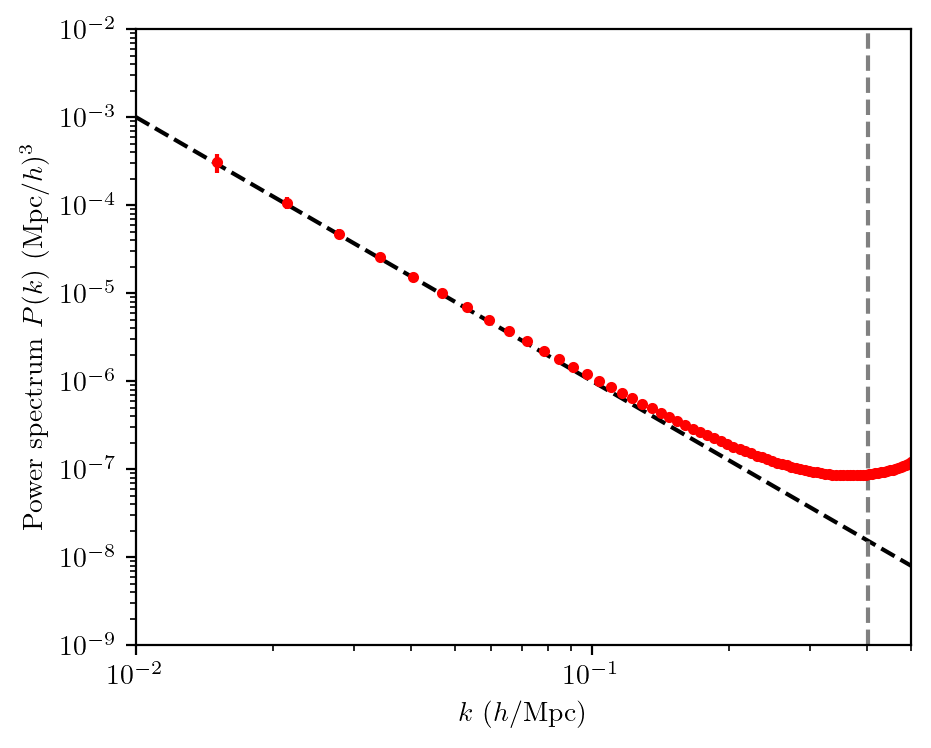

In [3]:
kmin = 2
kmax = 200
dk   = 1

k3D, Pk3D, Nmode3D = pngolin.compute_Pk3D_binned(delta_k, kmin, kmax, 1, box_len=BoxSize, 
                                                 nthreads=8, verbose=True)
Pk_err_gauss = np.sqrt(2*Pk3D**2/Nmode3D) # Gaussian covariance

plt.figure(figsize=(5,4))
plt.plot(k_thr, Pk_thr, color='k', linestyle='--')
plt.errorbar(k3D, Pk3D, yerr=Pk_err_gauss, linestyle='None', marker='.', color='r')
plt.axvline(kNyq, color='gray', linestyle='--')
plt.xlim(1e-2, 0.5)
plt.ylim(1e-9, 1e-2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k~(h/{\rm Mpc})$")
plt.ylabel(r"Power spectrum $P(k)~({\rm Mpc}/h)^3$")

##### **Bispectrum**

To compute the bispectrum, we specify the bin limits and widths for $k_1,k_2,k_3$. Note that the code computes all non-trivial bins with $k_1\leq k_2\leq k_3$. If you are computing the estimator for multiple realizations, then you only need to compute the number of triangle $N_{\rm tri}$ once and can then pass this to future calculations of estimators. 

1. INITIALIZING BINS
-> Total number of bins: 32
-> Number of unique k windows: 5
-> Time taken: 0.084 seconds
2. COMPUTING UNIQUE WINDOWED FIELDS AND THEIR IFFTS
-> Normalization not specified. Computing this too!
-> Time taken: 0.241 seconds
3. COMPUTING BINNED BISPECTRUM
-> Time taken: 0.086 seconds


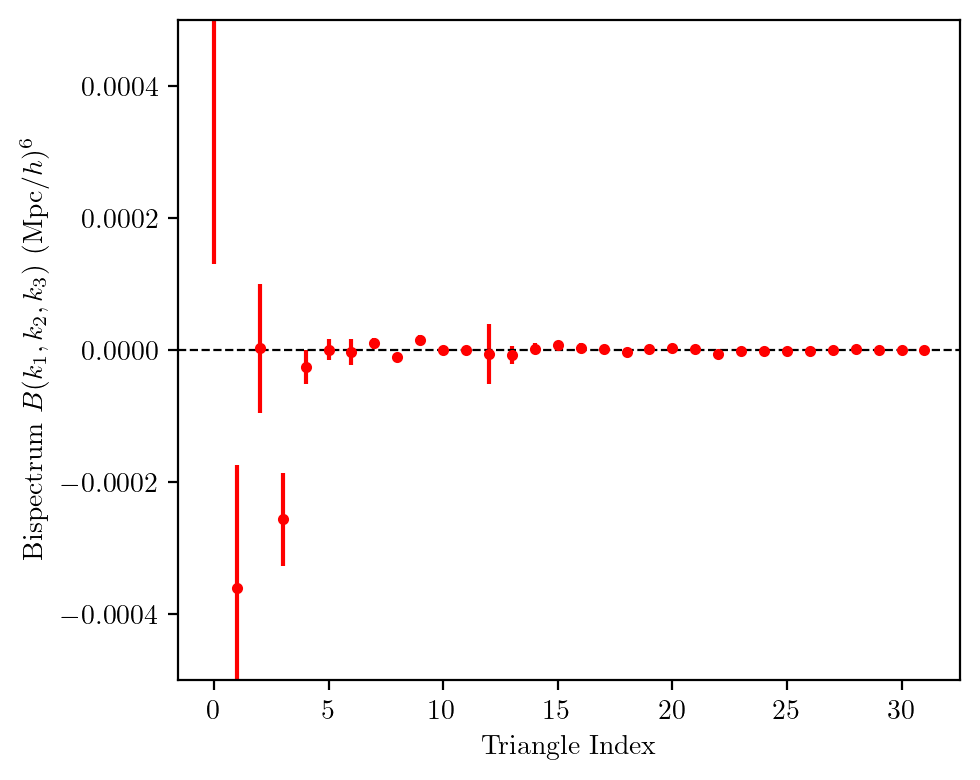

In [4]:
k1_min = 2
k1_max = 12
k2_min = 2
k2_max = 12
k3_min = 2
k3_max = 12
dk1 = 2
dk2 = 2
dk3 = 2


kBk, Bk_arr, Ntri_arr = pngolin.compute_bk3d(delta_k, k1_min, k1_max, k2_min, k2_max, k3_min, k3_max,
                                             dk1, dk2, dk3, BoxSize, nthreads=nthreads, verbose=True)

k1, k2, k3 = kBk.T # Get individual values of bins
tri_ind    = np.arange(len(k1)) # Triangle index

# Gaussian covariance
s123 = 1*np.ones_like(k1)
s123[np.where((k1==k2) | (k2==k3) |  (k3==k1))] = 2
s123[np.where((k1==k2) & (k2==k3))] = 6
V123 = 8*np.pi**2*k1*k2*k3*(dk1*kF)**3
Bk_err_gauss = (2*np.pi)**3*kF**3*s123*Pk_interp(k1)*Pk_interp(k2)*Pk_interp(k3)/V123

plt.figure(figsize=(5,4))
plt.errorbar(tri_ind, Bk_arr, yerr=np.sqrt(Bk_err_gauss), marker='.', color='r', linestyle='None')
plt.axhline(0.0, linestyle='--', color='k', linewidth=0.8)
plt.ylim(-0.0005, 0.0005)
plt.xlabel(r"Triangle Index")
plt.ylabel(r"Bispectrum $B(k_1,k_2,k_3)~({\rm Mpc}/h)^6$")

plt.tight_layout()

##### **Trispectrum**

To compute the binned trispectrum, we specify the bin limits and widths for $k_1,k_2,k_3,k_4$ and the internal mode $k_{12}$. Note that the code computes all non-trivial bins with $k_1\leq k_2\leq k_3$. If you are computing the estimator for multiple realizations, then you only need to compute the number of triangle $N_{\rm tri}$ once and can then pass this to future calculations of estimators. 

We first compute the power spectrum of each bin on FFT grid. This is the slowest part of the estimator and is used to estimate the disconnected terms. This step could be optimized significantly!

In [5]:
Pk_mesh = pngolin.construct_Pk_mesh(Ngrid, Pk_interp, BoxSize, nthreads)

In [17]:
# Trispectrum settings
k1_min = 4
k1_max = 10
k2_min = k1_min
k2_max = k1_max
k3_min = k1_min
k3_max = k1_max
k4_min = k1_min
k4_max = k1_max
k12_min = k1_min
k12_max = k1_max
dk1 = 1
dk2 = 1
dk3 = 1
dk4 = 1
dk12 = 1

# Compute once to determine normalization and P(k) disconnected term
kTk, Tk_tot_arr, Tk_disc_PP_arr, Tk_disc_PD_arr, Ntet_arr = pngolin.compute_tk3d(delta_k, k1_min, k1_max, k2_min, k2_max, k3_min,
                                                                                 k3_max, k4_min, k4_max, k12_min, k12_max, dk1, dk2, dk3, 
                                                                                 dk4, dk12, BoxSize, nthreads, verbose=True, Pk_mesh=Pk_mesh)

0. INITIALIAZING TRISPECTRUM CALCULATION
-> No normalization specified. Routine will compute normalization and realization independent disconnected term.
-> Time taken: 0.001 seconds
1. INITIALIZING BINS
-> Total number of bins: 733
-> Number of unique k windows: 6
-> Time taken: 0.014 seconds
2. COMPUTING UNIQUE WINDOWED FIELDS AND THEIR IFFTS
-> Time taken: 0.209 seconds
3. COMPUTING UNIQUE PRODUCTS OF WINDOWS AND THEIR FFTS
-> Time taken: 0.941 seconds
4. COMPUTING BINNED TRISPECTRUM
-> Time taken: 16.173 seconds


#### **Average over many realizations**

To illustrate how the treatment of disconnected terms impacts the variance of the estimator, we can average over many Gaussian random fields.

In [61]:
Nsim = 200

# Trispectrum
Nk_Tk = len(Tk_tot_arr)
Tkcd_mat = np.zeros((Nsim+1, Nk_Tk), dtype=float)
Tkd_PP_mat = np.zeros((Nsim+1, Nk_Tk), dtype=float)
Tkd_PD_mat =  np.zeros((Nsim+1, Nk_Tk), dtype=float)
Tkcd_mat[0] = Tk_tot_arr
Tkd_PP_mat[0] = Tk_disc_PP_arr
Tkd_PD_mat[0] = Tk_disc_PD_arr

# Loop over GRFs                      
for i in tqdm(range(Nsim)):
    
    # Generate GRF
    deltag = DFL.gaussian_field_3D(Ngrid, k_thr, Pk_thr, Rayleigh_sampling=1, seed=np.random.randint(0, 1e9),
                                       BoxSize=BoxSize, threads=10, verbose=False)
    deltak_i = pngolin.initialize_delta(deltag, MAS='CIC', nthreads=10)
    
    _, Tkcd_mat[i+1], Tkd_PP_mat[i+1], Tkd_PD_mat[i+1],_  = pngolin.compute_tk3d(deltak_i, k1_min, k1_max, k2_min, k2_max, k3_min,
                                                                                 k3_max, k4_min, k4_max, k12_min, k12_max, 
                                                                                 dk1, dk2, dk3, dk4, dk12, BoxSize, nthreads, verbose=False,
                                                                                 Pk_mesh=Pk_mesh,Tk_disc_PP_arr=Tk_disc_PP_arr, Ntet_arr=Ntet_arr)

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [09:48<00:00,  2.94s/it]


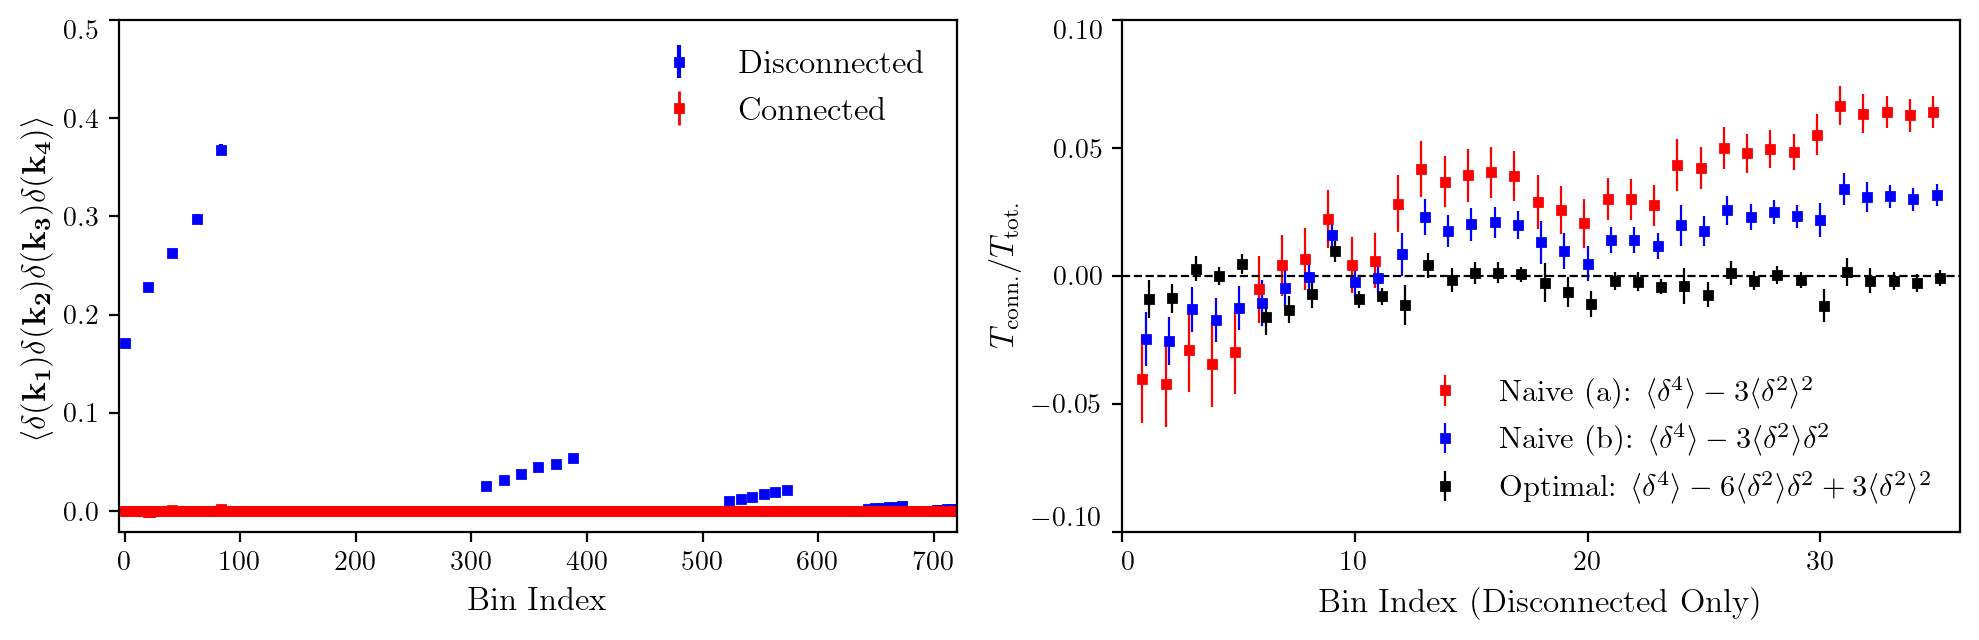

In [141]:
### Compute mean, error, ratios
bin_ind = np.arange(Nk_Tk)
Tkcd_mean = np.mean(Tkcd_mat, axis=0)
Tkd_PP_mean = np.mean(Tkd_PP_mat, axis=0)
Tkcd_std = np.std(Tkcd_mat, axis=0)/np.sqrt(Nsim)
Tkd_PP_std = np.std(Tkd_PP_mat, axis=0)/np.sqrt(Nsim)
disc_inds = np.where(Tkd_PP_mean!=0)
disc_rat_err  = np.std((Tkd_PP_mat/Tkcd_mat), axis=0)[disc_inds]/np.sqrt(Nsim)
disc_rat_mean = np.mean((Tkd_PP_mat/Tkcd_mean), axis=0)[disc_inds]

plt.figure(figsize=(10,3.3))


############################################################
# Compare connected and disconnected terms
############################################################
plt.subplot(1,2,1)
Tk_connected = (Tkcd_mat-Tkd_PD_mat+Tkd_PP_mat)
Tk_connected_mean = np.mean(Tk_connected, axis=0)
Tk_connected_std = np.std(Tk_connected, axis=0)/np.sqrt(Nsim)

plt.errorbar(bin_ind, Tkcd_mean, yerr=Tkcd_std, marker='s', markersize=2.8, color='b', linestyle='None', label='Disconnected')
plt.errorbar(bin_ind, np.mean(Tk_connected, axis=0), yerr=np.std(Tk_connected,axis=0)/np.sqrt(Nsim), 
             marker='s', markersize=2.8,linestyle='none', color='r', label=r'Connected', elinewidth=1)
plt.legend(frameon=False, fontsize=12)
plt.axhline(0., linestyle='--', color='k')
#plt.yticks([])
#plt.xticks([0, 10, 20, 30, 40])
plt.xlim(-5, 720)
plt.yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
#plt.ylim(-0.0012, top=0.0012)
plt.xlabel(r"Bin Index", fontsize=12)
plt.ylabel(r"$\langle \delta({\bf{k_1}})\delta({\bf{k_2}})\delta({\bf{k_3}})\delta({\bf{k_4}})\rangle$ ", fontsize=12)
ax = plt.gca()
ax.xaxis.get_majorticklabels()[0].set_horizontalalignment('left')
ax.yaxis.get_majorticklabels()[-1].set_verticalalignment('top')

############################################################
# Compare different ways of subtracting disconnected terms
############################################################
plt.subplot(1,2,2)


# Optimal estimator
Tk_connected = (Tkcd_mat-Tkd_PD_mat+Tkd_PP_mat)/Tkcd_mat
Tk_connected_mean = np.mean(Tk_connected, axis=0)
Tk_connected_std = np.std(Tk_connected, axis=0)/np.sqrt(Nsim)


# Naive estimators
Tk_mat_a = (Tkcd_mat-Tkd_PP_mat)/Tkcd_mat
Tk_mat_b = (Tkcd_mat-Tkd_PD_mat/2)/Tkcd_mat


bin_disc_inds = np.arange(len(disc_inds[0]))+1

plt.errorbar(bin_disc_inds-0.15, np.mean(Tk_mat_a, axis=0)[disc_inds], yerr=np.std(Tk_mat_a,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='r', label=r'Naive (a): $\langle \delta^4\rangle-3\langle \delta^2\rangle^2$',
             elinewidth=0.8)
plt.errorbar(bin_disc_inds, np.mean(Tk_mat_b, axis=0)[disc_inds], yerr=np.std(Tk_mat_b,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='b', label=r'Naive (b): $\langle \delta^4\rangle-3\langle \delta^2\rangle\delta^2$',
             elinewidth=0.8)
plt.errorbar(bin_disc_inds+0.15, np.mean(Tk_connected, axis=0)[disc_inds], yerr=np.std(Tk_connected,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='k', label=r'Optimal: $\langle \delta^4\rangle-6\langle \delta^2\rangle\delta^2+3\langle \delta^2\rangle^2$',
             elinewidth=0.8)
plt.axhline(0.0, linestyle='--', color='k', linewidth=0.8)
plt.legend(frameon=False, fontsize=11, loc='lower right')
plt.xlabel("Bin Index (Disconnected Only)", fontsize=12)
plt.ylabel(r"$T_{\rm conn.}/T_{\rm tot.}$", fontsize=12)
#plt.yticks([])
plt.xticks([0, 10, 20, 30])
plt.xlim(0, 36)
plt.ylim(-0.1, 0.1)
plt.yticks([-0.1, -0.05, 0, 0.05, 0.1])
ax = plt.gca()
ax.xaxis.get_majorticklabels()[0].set_horizontalalignment('left')
ax.yaxis.get_majorticklabels()[0].set_verticalalignment('bottom')
ax.yaxis.get_majorticklabels()[-1].set_verticalalignment('top')
plt.tight_layout()
plt.savefig("fig_trispectrum_disc_validation.pdf")

In [82]:
Tk_connected = (Tkcd_mat-Tkd_PD_mat+Tkd_PP_mat)
Tk_connected_mean = np.mean(Tk_connected, axis=0)
Tk_connected_std = np.std(Tk_connected, axis=0)/np.sqrt(Nsim)
print(np.sum(Tk_connected_mean**2/Tk_connected_std**2)/len(Tk_connected_mean))
print(np.sum((Tk_connected_mean**2/Tk_connected_std**2)[disc_inds])/len(Tk_connected_mean[disc_inds]))

1.2385175026034645
1.1808509591274994


In [83]:
np.sum((Tk_connected_mean**2/(Tk_connected_std**2))

SyntaxError: unexpected EOF while parsing (3716342367.py, line 1)

In [102]:
inds = np.sort((Tk_connected_mean**2)/(Tk_connected_std**2))

In [110]:
inds[-30]

5.665113182034507

In [101]:
disc_inds

(array([  0,  20,  41,  62,  83, 313, 328, 343, 358, 373, 388, 523, 533,
        543, 553, 563, 573, 643, 649, 655, 661, 667, 673, 703, 706, 709,
        712, 715, 718, 727, 728, 729, 730, 731, 732]),)

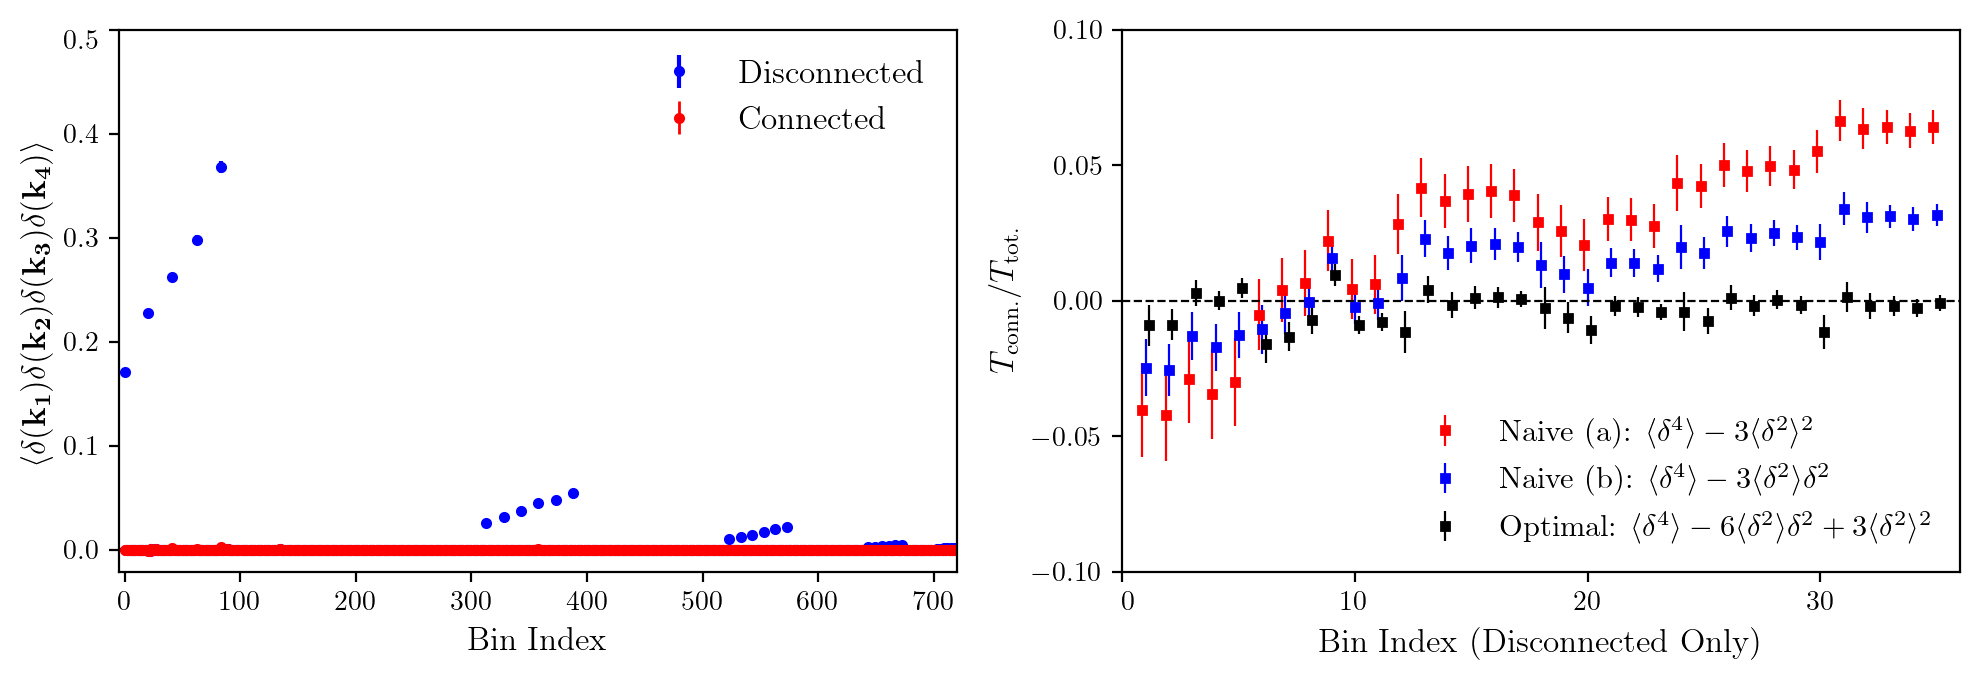

In [140]:
### Compute mean, error, ratios
bin_ind = np.arange(Nk_Tk)
Tkcd_mean = np.mean(Tkcd_mat, axis=0)
Tkd_PP_mean = np.mean(Tkd_PP_mat, axis=0)
Tkcd_std = np.std(Tkcd_mat, axis=0)/np.sqrt(Nsim)
Tkd_PP_std = np.std(Tkd_PP_mat, axis=0)/np.sqrt(Nsim)
disc_inds = np.where(Tkd_PP_mean!=0)
disc_rat_err  = np.std((Tkd_PP_mat/Tkcd_mat), axis=0)[disc_inds]/np.sqrt(Nsim)
disc_rat_mean = np.mean((Tkd_PP_mat/Tkcd_mean), axis=0)[disc_inds]

plt.figure(figsize=(10,3.5))


############################################################
# Compare connected and disconnected terms
############################################################
plt.subplot(1,2,1)
Tk_connected = (Tkcd_mat-Tkd_PD_mat+Tkd_PP_mat)
Tk_connected_mean = np.mean(Tk_connected, axis=0)
Tk_connected_std = np.std(Tk_connected, axis=0)/np.sqrt(Nsim)

plt.errorbar(bin_ind, Tkcd_mean, yerr=Tkcd_std, marker='.', color='b', linestyle='None', label='Disconnected')
plt.errorbar(bin_ind, np.mean(Tk_connected, axis=0), yerr=np.std(Tk_connected,axis=0)/np.sqrt(Nsim), 
             marker='.',linestyle='none', color='r', label=r'Connected', elinewidth=1)
plt.legend(frameon=False, fontsize=12)
plt.axhline(0., linestyle='--', color='k')
#plt.yticks([])
#plt.xticks([0, 10, 20, 30, 40])
plt.xlim(-5, 720)
plt.yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
#plt.ylim(-0.0012, top=0.0012)
plt.xlabel(r"Bin Index", fontsize=12)
plt.ylabel(r"$\langle \delta({\bf{k_1}})\delta({\bf{k_2}})\delta({\bf{k_3}})\delta({\bf{k_4}})\rangle$ ", fontsize=12)
ax = plt.gca()
ax.xaxis.get_majorticklabels()[0].set_horizontalalignment('left')
ax.yaxis.get_majorticklabels()[-1].set_verticalalignment('top')

############################################################
# Compare different ways of subtracting disconnected terms
############################################################
plt.subplot(1,2,2)


# Optimal estimator
Tk_connected = (Tkcd_mat-Tkd_PD_mat+Tkd_PP_mat)/Tkcd_mat
Tk_connected_mean = np.mean(Tk_connected, axis=0)
Tk_connected_std = np.std(Tk_connected, axis=0)/np.sqrt(Nsim)


# Naive estimators
Tk_mat_a = (Tkcd_mat-Tkd_PP_mat)/Tkcd_mat
Tk_mat_b = (Tkcd_mat-Tkd_PD_mat/2)/Tkcd_mat


bin_disc_inds = np.arange(len(disc_inds[0]))+1

plt.errorbar(bin_disc_inds-0.15, np.mean(Tk_mat_a, axis=0)[disc_inds], yerr=np.std(Tk_mat_a,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='r', label=r'Naive (a): $\langle \delta^4\rangle-3\langle \delta^2\rangle^2$',
             elinewidth=0.8)
plt.errorbar(bin_disc_inds, np.mean(Tk_mat_b, axis=0)[disc_inds], yerr=np.std(Tk_mat_b,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='b', label=r'Naive (b): $\langle \delta^4\rangle-3\langle \delta^2\rangle\delta^2$',
             elinewidth=0.8)
plt.errorbar(bin_disc_inds+0.15, np.mean(Tk_connected, axis=0)[disc_inds], yerr=np.std(Tk_connected,axis=0)[disc_inds]/np.sqrt(Nsim), 
             marker='s', markersize=2.8, linestyle='none', color='k', label=r'Optimal: $\langle \delta^4\rangle-6\langle \delta^2\rangle\delta^2+3\langle \delta^2\rangle^2$',
             elinewidth=0.8)
plt.axhline(0.0, linestyle='--', color='k', linewidth=0.8)
plt.legend(frameon=False, fontsize=11, loc='lower right')
plt.xlabel("Bin Index (Disconnected Only)", fontsize=12)
plt.ylabel(r"$T_{\rm conn.}/T_{\rm tot.}$", fontsize=12)
#plt.yticks([])
plt.xticks([0, 10, 20, 30])
plt.xlim(0, 36)
plt.ylim(-0.1, 0.1)
plt.yticks([-0.1, -0.05, 0, 0.05, 0.1])
ax = plt.gca()
ax.xaxis.get_majorticklabels()[0].set_horizontalalignment('left')
plt.tight_layout()
plt.savefig("fig_trispectrum_disc_validation.pdf")

In [47]:
Pk3D

733

In [137]:
(k3D/kF)[2:6]

array([4.43033372, 5.46713111, 6.44241187, 7.44322578])

In [138]:
Pk3D[2:6]/Pk_interp(k3D[2:6])

array([1.02749222, 1.03154072, 1.02584253, 1.03189823])